# 1. Data Pre-processing

Import Datasets

In [439]:
import pandas as pd
df = pd.read_csv('../dataset/amazon_datasets.csv')
print(df)

        ID      product_title        user_name  rating  \
0        1   OnePlus Nord N30           forest       5   
1        2   OnePlus Nord N30             Drew       5   
2        3   OnePlus Nord N30           forest       4   
3        4   OnePlus Nord N30  Amazon Customer       5   
4        5   OnePlus Nord N30           C Jack       5   
...    ...                ...              ...     ...   
4569  4570  Samsung Galaxy J3       Leo Maneke       4   
4570  4571  Samsung Galaxy J3       nearoffutt       1   
4571  4572  Samsung Galaxy J3  SammiJo Skinner       5   
4572  4573  Samsung Galaxy J3          Meowkie       1   
4573  4574  Samsung Galaxy J3       Athenasowl       5   

                                                 review         review_date  
0     I bought this phone at the recommendation of a...        May 19, 2024  
1     I have this phone for a few months now and for...       July 26, 2024  
2     I like that this phone has a good battery life...     January 2

Clean Review

In [440]:
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# General Preprocessing (normalization, spaces)
def basic_preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text


# VADER Preprocessing
def preprocess_vader(text):
    if not isinstance(text, str):
        return ""
    return basic_preprocess(text)


# Transformer Models Preprocessing (keep meaningful punctuation)
def preprocess_transformers(text):
    if not isinstance(text, str):
        return ""
    text = basic_preprocess(text)
    text = re.sub(r'[^\w\s,!?]', '', text) # Remove punctuation except meaningful ones
    return text


# Deep Learning Models (CNN, LSTM) Preprocessing (Remove punctuation)
def preprocess_dl_models(text):
    if not isinstance(text, str):
        return ""
    text = basic_preprocess(text)
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text


# SVM Preprocessing (Remove punctuation, and stop words)
def preprocess_svm(text):
    if not isinstance(text, str):
        return ""
    text = basic_preprocess(text)
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stop words
    return text


# Assign Sentiment on the basis of customer ratings
def assign_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating == 3:
        return 0
    else:
        return -1

Applyin Preprocess

In [441]:
df['vader']         =   df['review'].apply(preprocess_vader)
df['transformers']  =   df['review'].apply(preprocess_transformers)
df['cnn_lstm']      =   df['review'].apply(preprocess_dl_models)
df['svm']           =   df['review'].apply(preprocess_svm)
df['sentiment']     =   df['rating'].apply(assign_sentiment)

df.to_csv('clean_datasets.csv', index=False)

df = df.head(500)
df.head()
# df.shape

,ID,product_title,user_name,rating,review,review_date,vader,transformers,cnn_lstm,svm,sentiment
0,1,OnePlus Nord N30,forest,5,I bought this phone at the recommendation of a...,"May 19, 2024",i bought this phone at the recommendation of a...,i bought this phone at the recommendation of a...,i bought this phone at the recommendation of a...,bought phone recommendation friend happy im so...,1
1,2,OnePlus Nord N30,Drew,5,I have this phone for a few months now and for...,"July 26, 2024",i have this phone for a few months now and for...,i have this phone for a few months now and for...,i have this phone for a few months now and for...,phone months price great phone looking somethi...,1
2,3,OnePlus Nord N30,forest,4,I like that this phone has a good battery life...,"January 2, 2024",i like that this phone has a good battery life...,i like that this phone has a good battery life...,i like that this phone has a good battery life...,like phone good battery life charges superfast...,1
3,4,OnePlus Nord N30,Amazon Customer,5,Short version: I got this for my mom since she...,"August 10, 2024",short version: i got this for my mom since she...,short version i got this for my mom since she ...,short version i got this for my mom since she ...,short version got mom since habit buying cheap...,1
4,5,OnePlus Nord N30,C Jack,5,I have a Samsung s22 Ultra. I've been having b...,"May 27, 2024",i have a samsung s ultra. i've been having bat...,i have a samsung s ultra ive been having batte...,i have a samsung s ultra ive been having batte...,samsung ultra ive battery connectivity issues ...,1


# 2. Splitting Data

Split Data Into Train and Test Set

In [442]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, X_vader_train, X_vader_test, X_transformers_train, X_transformers_test, X_cnn_lstm_train, X_cnn_lstm_test, X_svm_train, X_svm_test, y_train, y_test = train_test_split(
    df['review'], df['vader'], df['transformers'], df['cnn_lstm'], df['svm'], df['sentiment'], test_size=0.2, random_state=42)

# 3. Model Building

### 3.1. Transformer-Based Models: ( BERT, RoBERTa )

In [443]:
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_sentiment(positive, negative, neutral):
    if positive > negative and positive > neutral:
        return positive 
    elif negative > positive and negative > neutral:
        return -negative 
    else:
        return positive - negative

def preprocess_transformers(texts, tokenizer, max_length=128):
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    return inputs

##### 3.1.1 BERT Model Build

In [444]:
from transformers import BertTokenizer, BertForSequenceClassification

bert_tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment', clean_up_tokenization_spaces=True)
bert_model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def bert_sentiment(text):
    bert_inputs = preprocess_transformers([text], bert_tokenizer)
    bert_inputs = {key: val.to(device) for key, val in bert_inputs.items()}
    with torch.no_grad():
        bert_output = bert_model(**bert_inputs).logits
    probabilities = F.softmax(bert_output, dim=-1)
    positive_class_prob = probabilities[0, 1].item()
    negative_class_prob = probabilities[0, 0].item()
    neutral_class_prob = probabilities[0, 2].item()
    return predict_sentiment(positive_class_prob, negative_class_prob, neutral_class_prob)

##### 3.1.2 RoBERTa Model Build

In [445]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment', clean_up_tokenization_spaces=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

def roberta_sentiment(text):
    roberta_inputs = preprocess_transformers([text], roberta_tokenizer)
    roberta_inputs = {key: val.to(device) for key, val in roberta_inputs.items()}  
    with torch.no_grad():
        roberta_output = roberta_model(**roberta_inputs).logits
    probabilities = F.softmax(roberta_output, dim=-1)
    positive_class_prob = probabilities[0, 1].item()
    negative_class_prob = probabilities[0, 0].item()
    neutral_class_prob = probabilities[0, 2].item()
    return predict_sentiment(positive_class_prob, negative_class_prob, neutral_class_prob)

#### 3.2. Lexicon-Based Approaches: ( VADER, TextBlob)

##### 3.2.1 VADER Model

In [446]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    return vader_analyzer.polarity_scores(text)['compound']

##### 3.2.2 TextBlob

In [447]:
from textblob import TextBlob
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

## 3.3. Machine Learning Model: SVM with TF-IDF

In [448]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# SVM Model definition using TF-IDF Vectorizer
svm_model = make_pipeline(TfidfVectorizer(max_features=5000), SVC(probability=True))

# Training the SVM model
svm_model.fit(X_svm_train, y_train)

# SVM Sentiment Prediction function
def svm_sentiment(text):
    probabilities = svm_model.predict_proba([text])[0]
    negative_prob = probabilities[0]
    positive_prob = probabilities[2]
    return positive_prob - negative_prob

## 3.4. Deep Learning Models: (LSTM, CNN)

In [449]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_cnn_lstm_train)
X_train_seq = tokenizer.texts_to_sequences(X_cnn_lstm_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')

##### 3.4.1 LSTM Model Train and Build

In [450]:
def build_lstm():
    model = Sequential()
    model.add(Embedding(10000, 100))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = build_lstm()
lstm_model.fit(X_train_pad, np.array(y_train), epochs=5, batch_size=32, validation_split=0.2)

def lstm_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=100, padding='post')
    positive_prob = lstm_model.predict(padded_sequence)[0][0]
    negative_prob = 1 - positive_prob
    return positive_prob - negative_prob

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.7051 - loss: 0.6464 - val_accuracy: 0.7750 - val_loss: 0.9818
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8383 - loss: 0.6592 - val_accuracy: 0.7750 - val_loss: 0.6125
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.8299 - loss: 0.5383 - val_accuracy: 0.7750 - val_loss: 0.6095
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8339 - loss: 0.5015 - val_accuracy: 0.7750 - val_loss: 0.6568
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8522 - loss: 0.4588 - val_accuracy: 0.7875 - val_loss: 0.5996


##### 3.4.2 CNN Model Build

In [451]:
def build_cnn():
    model = Sequential()
    model.add(Embedding(10000, 100))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = build_cnn()
cnn_model.fit(X_train_pad, np.array(y_train), epochs=5, batch_size=32, validation_split=0.2)

def cnn_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=100, padding='post')
    positive_prob = cnn_model.predict(padded_sequence)[0][0]
    negative_prob = 1 - positive_prob
    return positive_prob - negative_prob

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7110 - loss: 0.6329 - val_accuracy: 0.7750 - val_loss: 0.7334
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8137 - loss: 0.5810 - val_accuracy: 0.7750 - val_loss: 0.6310
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8523 - loss: 0.4427 - val_accuracy: 0.7750 - val_loss: 0.6422
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8233 - loss: 0.4232 - val_accuracy: 0.7750 - val_loss: 0.6197
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8515 - loss: 0.3300 - val_accuracy: 0.7750 - val_loss: 0.6286


## 3.5. Hybrid Model

In [452]:
def sentiment_tag(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

def dl_sentiment_tag(score):
    if score > 0.55:
        return "Positive"
    elif score < 0.45:
        return "Negative"
    else:
        return "Neutral"

In [453]:
def hybrid_model(text, vader_text, transformers_text, cnn_lstm_text, svm_text):
    vader_score = vader_sentiment(vader_text)
    roberta_score = roberta_sentiment(transformers_text)
    bert_score = bert_sentiment(transformers_text)
    textblob_score = textblob_sentiment(text)
    svm_score = svm_sentiment(svm_text)
    cnn_score = cnn_sentiment(cnn_lstm_text)
    lstm_score= lstm_sentiment(cnn_lstm_text)
    hybrid_score = np.mean([vader_score, roberta_score, bert_score, textblob_score, svm_score])

    # Assign Sentiment Tags
    sentiment_vader = sentiment_tag(vader_score)
    sentiment_textblob = sentiment_tag(textblob_score)
    sentiment_roberta = sentiment_tag(roberta_score)
    sentiment_bert = sentiment_tag(bert_score)
    sentiment_cnn = dl_sentiment_tag(cnn_score)
    sentiment_lstm = dl_sentiment_tag(lstm_score)
    sentiment_svm = sentiment_tag(svm_score)
    sentiment_hybrid = sentiment_tag(hybrid_score)

    comparison = {
        "text": text,
        "vader_score":  vader_score,
        "textblob_score":  textblob_score,
        "roberta_score":  roberta_score,
        "bert_score":  bert_score,
        "cnn_score":  cnn_score,
        "lstm_score":  lstm_score,
        "svm_score":  svm_score,
        "hybrid_score":  hybrid_score,
        'vader_sentiment': sentiment_vader,
        'textblob_sentiment': sentiment_textblob,
        'roberta_sentiment': sentiment_roberta,
        'bert_sentiment': sentiment_bert,
        'cnn_sentiment': sentiment_cnn,
        'lstm_sentiment': sentiment_lstm,
        'svm_sentiment': sentiment_svm,
        'hybrid_sentiment': sentiment_hybrid,
    }

    return comparison

In [456]:
df['review'] = df['review'].fillna('').astype(str)
min_length = min(len(X_text_test), len(X_vader_test), len(X_transformers_test), len(X_cnn_lstm_test), len(X_svm_test))

texts = X_text_test[:min_length].reset_index(drop=True)
vader_texts = X_vader_test[:min_length].reset_index(drop=True)
transformers_texts = X_transformers_test[:min_length].reset_index(drop=True)
cnn_lstm_texts = X_cnn_lstm_test[:min_length].reset_index(drop=True)
svm_texts = X_svm_test[:min_length].reset_index(drop=True)

results_list = []

# Iterate over your dataset
for i, text in enumerate(texts):
    comparison = hybrid_model(text, vader_texts[i], transformers_texts[i], cnn_lstm_texts[i], svm_texts[i])
    results_list.append(comparison)


results_list = pd.DataFrame(results_list)
results_list.to_csv('sentiment_results.csv', index=False)

print("Results saved to sentiment_results.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

# 4. Compare models sentiment

In [458]:
def accuracy_hybrid_model(text, vader_text, transformers_text, cnn_lstm_text, svm_text):
    vader_score = vader_sentiment(vader_text)
    roberta_score = roberta_sentiment(transformers_text)
    bert_score = bert_sentiment(transformers_text)
    textblob_score = textblob_sentiment(text)
    svm_score = svm_sentiment(svm_text)
    cnn_score = cnn_sentiment(cnn_lstm_text)
    lstm_score= lstm_sentiment(cnn_lstm_text)
    
    hybrid_score = np.mean([vader_score, roberta_score, bert_score, textblob_score, svm_score, cnn_score, lstm_score])
    return hybrid_score

In [460]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_vader = [vader_sentiment(text) for text in X_vader_test]
y_pred_roberta = [roberta_sentiment(text) for text in X_transformers_test]
y_pred_bert = [bert_sentiment(text) for text in X_transformers_test]
y_pred_textblob = [textblob_sentiment(text) for text in X_text_test]
y_pred_svm = [svm_sentiment(text) for text in X_svm_test]
y_pred_cnn = [cnn_sentiment(text) for text in X_cnn_lstm_test]
y_pred_lstm = [lstm_sentiment(text) for text in X_cnn_lstm_test]
y_pred_hybrid = [accuracy_hybrid_model(text, vader_text, transformers_text, cnn_lstm_text, svm_text) 
                 for text, vader_text, transformers_text, cnn_lstm_text, svm_text 
                 in zip(X_text_test, X_vader_test, X_transformers_test, X_cnn_lstm_test, X_svm_test)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [466]:
print("VADER Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='macro'))

print("RoBERTa Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='macro'))

print("BERT Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='macro'))

print("TextBlob Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='macro'))

print("SVM Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='macro'))

print("CNN Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='macro'))

print("LSTM Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='macro'))

print("Hybrid Model:")
print("Accuracy:", accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid]))
print("Precision (macro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='macro', zero_division=0))
print("Precision (micro):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='micro', zero_division=0))
print("Precision (weighted):", precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='macro'))
print("F1-measure:", f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='macro'))

VADER Model:
Accuracy: 0.67
Precision (macro): 0.33187134502923976
Precision (micro): 0.67
Precision (weighted): 0.633421052631579
Recall: 0.3948948948948949
F1-measure: 0.35407407407407404
RoBERTa Model:
Accuracy: 0.73
Precision (macro): 0.36628491058870805
Precision (micro): 0.73
Precision (weighted): 0.6655334538878843
Recall: 0.4451951951951952
F1-measure: 0.3973063973063973
BERT Model:
Accuracy: 0.67
Precision (macro): 0.3205345379258423
Precision (micro): 0.67
Precision (weighted): 0.6307171089779786
Recall: 0.37162162162162166
F1-measure: 0.3397035635446231
TextBlob Model:
Accuracy: 0.7
Precision (macro): 0.32941176470588235
Precision (micro): 0.7
Precision (weighted): 0.6072941176470588
Recall: 0.3851351351351351
F1-measure: 0.3549965059399021
SVM Model:
Accuracy: 0.76
Precision (macro): 0.3543743078626799
Precision (micro): 0.76
Precision (weighted): 0.6538538205980067
Recall: 0.4121621621621621
F1-measure: 0.38108974358974357
CNN Model:
Accuracy: 0.74
Precision (macro): 0.246

In [461]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models = ["VADER", "RoBERTa", "BERT", "TextBlob", "SVM", "CNN", "LSTM", "Hybrid"]

accuracy = [accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm]),
            accuracy_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid])]

In [462]:
precision_macro = [precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='macro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='macro', zero_division=0)]

precision_micro = [precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='micro', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='micro', zero_division=0)]


precision_weighted = [precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='weighted', zero_division=0),
                   precision_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='weighted', zero_division=0)]

In [463]:
recall = [recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='micro'),
            recall_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='micro')]

In [464]:
F1score = [f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_vader], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_roberta], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_bert], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_textblob], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_svm], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_cnn], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_lstm], average='micro'),
            f1_score(y_test, [1 if score > 0 else 0 for score in y_pred_hybrid], average='micro')]

C:\Users\User\AppData\Local\Temp\ipykernel_23092\1112127467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='viridis')


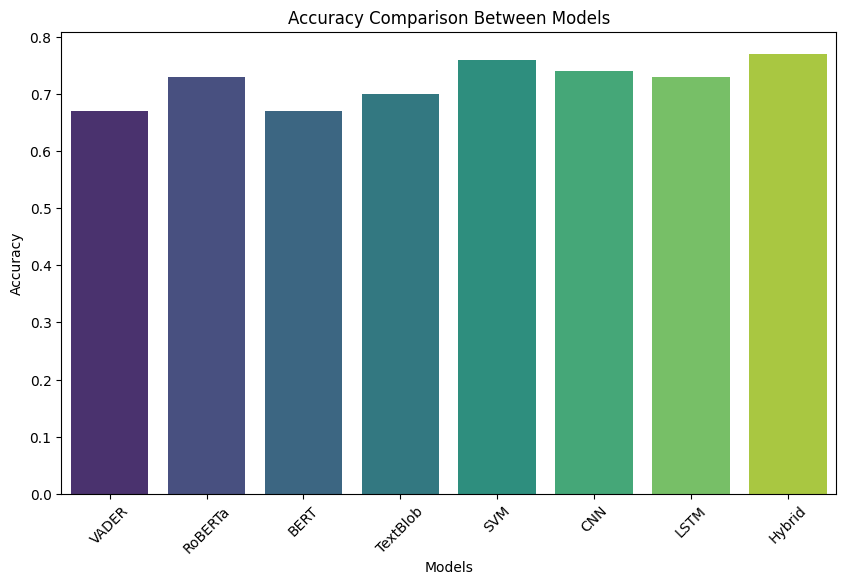

C:\Users\User\AppData\Local\Temp\ipykernel_23092\1112127467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='viridis')


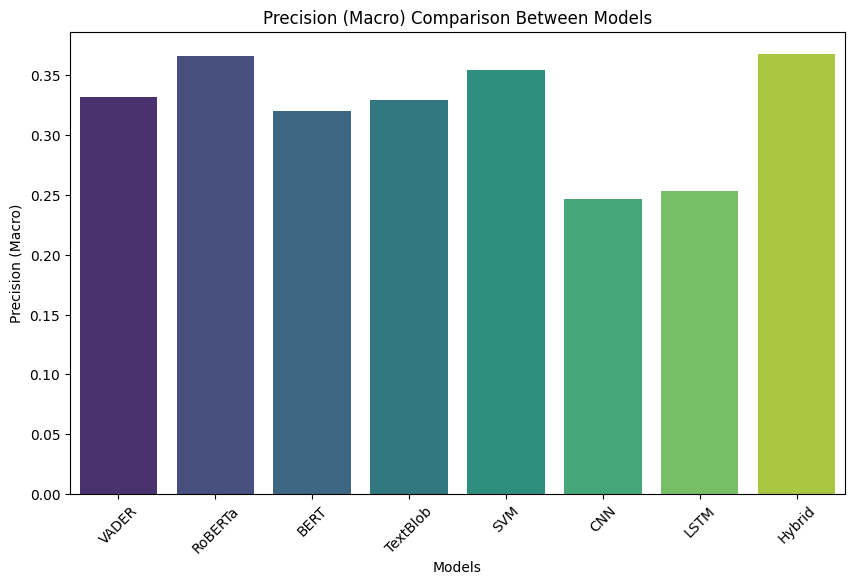

C:\Users\User\AppData\Local\Temp\ipykernel_23092\1112127467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='viridis')


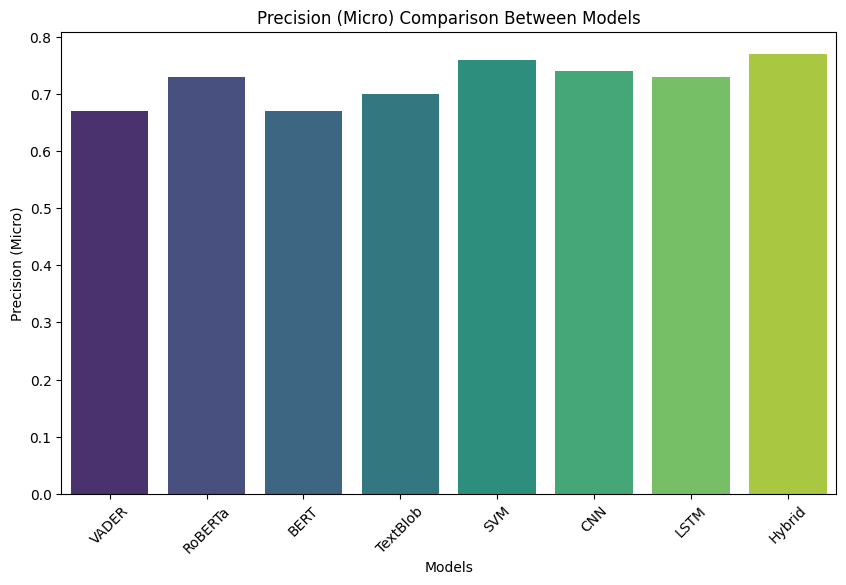

C:\Users\User\AppData\Local\Temp\ipykernel_23092\1112127467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='viridis')


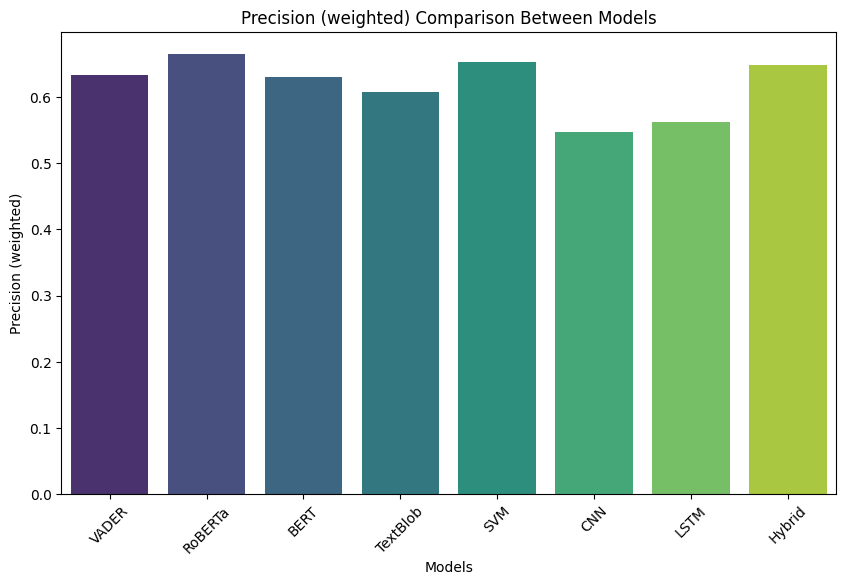

C:\Users\User\AppData\Local\Temp\ipykernel_23092\1112127467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='viridis')


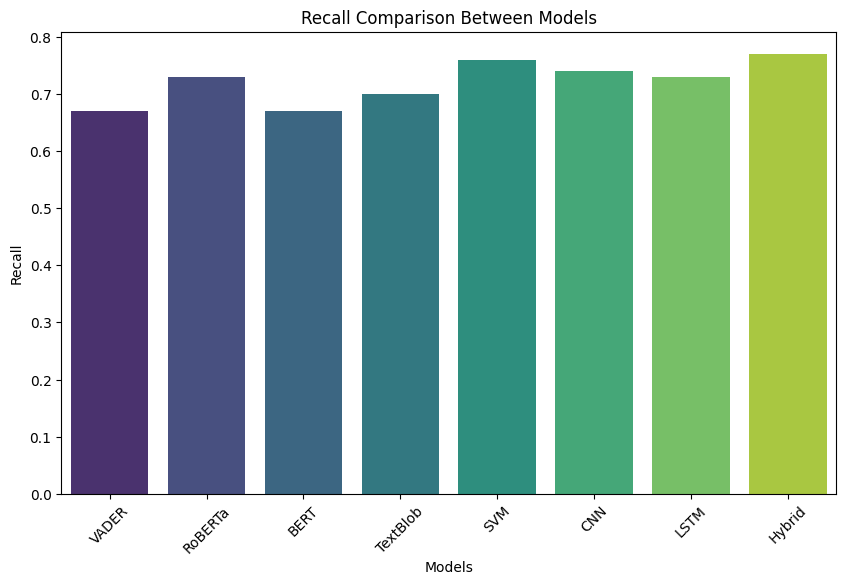

C:\Users\User\AppData\Local\Temp\ipykernel_23092\1112127467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=metric, palette='viridis')


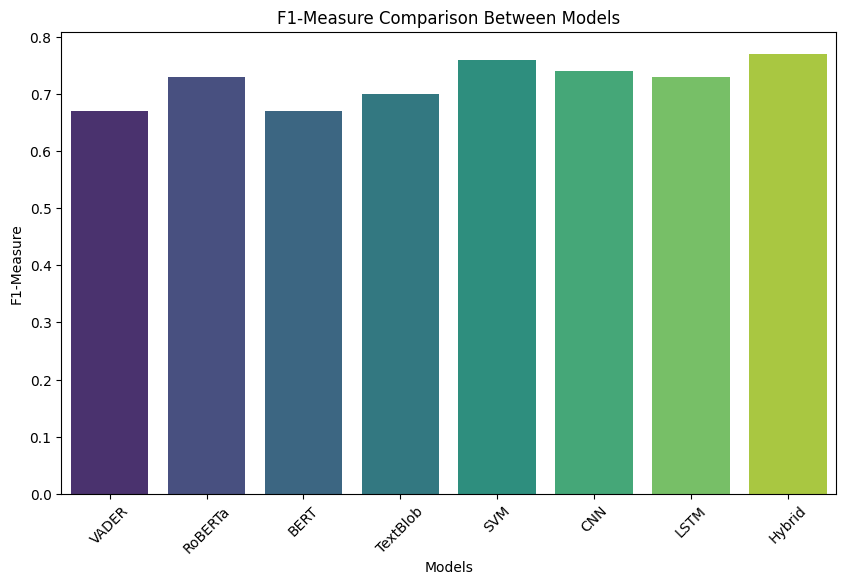

[0.67, 0.73, 0.67, 0.7, 0.76, 0.74, 0.73, 0.77]
[0.33187134502923976, 0.36628491058870805, 0.3205345379258423, 0.32941176470588235, 0.3543743078626799, 0.24666666666666667, 0.2534722222222222, 0.36806264896152535]
[0.67, 0.73, 0.67, 0.7, 0.76, 0.74, 0.73, 0.77]
[0.633421052631579, 0.6655334538878843, 0.6307171089779786, 0.6072941176470588, 0.6538538205980067, 0.5476, 0.5627083333333333, 0.6480081716036773]
[0.67, 0.73, 0.67, 0.7, 0.76, 0.74, 0.73, 0.77]
[0.67, 0.73, 0.67, 0.7, 0.76, 0.74, 0.73, 0.77]


In [465]:
# Function to plot bar graphs
def plot_metric(models, metric, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=metric, palette='viridis')
    plt.title(f"{metric_name} Comparison Between Models")
    plt.xlabel("Models")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

# Plot Accuracy
plot_metric(models, accuracy, "Accuracy", "Accuracy")

# Plot Precision (Macro)
plot_metric(models, precision_macro, "Precision (Macro)", "Precision (Macro)")

# Plot Precision (Micro)
plot_metric(models, precision_micro, "Precision (Micro)", "Precision (Micro)")

# Plot Precision (weighted)
plot_metric(models, precision_weighted, "Precision (weighted)", "Precision (weighted)")

# Plot Recall
plot_metric(models, recall, "Recall", "Recall")

# Plot F1-Measure
plot_metric(models, F1score, "F1-Measure", "F1-Measure")

print(accuracy)
print(precision_macro)
print(precision_micro)
print(precision_weighted)
print(recall)
print(F1score)